In [8]:
# Cell 1: Import libraries and set paths
import numpy as np
import pandas as pd
from sklearn.ensemble import IsolationForest
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

# Define paths
processed_train_path = '/root/autodl-tmp/projects/USL_NSL/dataset/processed/multi/KDDTrain_processed.csv'
processed_test_path = '/root/autodl-tmp/projects/USL_NSL/dataset/processed/multi/KDDTest_processed.csv'
train_labels_path = '/root/autodl-tmp/projects/USL_NSL/dataset/processed/multi/KDDTrain_labels.csv'
test_labels_path = '/root/autodl-tmp/projects/USL_NSL/dataset/processed/multi/KDDTest_labels.csv'

# Load class names mapping
preprocessing_path = '/root/autodl-tmp/projects/USL_NSL/dataset/processed/multi/preprocessing_objects.pkl'
with open(preprocessing_path, 'rb') as f:
    preprocessing_objects = pickle.load(f)
    class_names = preprocessing_objects['class_names']

In [9]:
# Cell 2: Load and prepare data
print("Loading training data...")
df_train = pd.read_csv(processed_train_path)
X = df_train.drop('multiclass_label', axis=1).values
y = df_train['multiclass_label'].values

# Split training set and validation set (80-20)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Display number of samples for each class
class_dist = pd.Series(y).value_counts().sort_index()
print("\nClass distribution in training data:")
for class_id, count in class_dist.items():
    print(f"Class {class_id} ({class_names[class_id]}): {count} samples ({count/len(y)*100:.2f}%)")

# Display data information
print("\nDataset shapes:")
print(f"Training set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")
print("Loading complete!")

Loading training data...

Class distribution in training data:
Class 0 (Normal Traffic): 67343 samples (53.46%)
Class 1 (DOS (Denial of Service)): 45927 samples (36.46%)
Class 2 (Probe (Surveillance/Scanning)): 11656 samples (9.25%)
Class 3 (R2L (Remote to Local)): 995 samples (0.79%)
Class 4 (U2R (User to Root)): 52 samples (0.04%)

Dataset shapes:
Training set: (100778, 43)
Validation set: (25195, 43)
Loading complete!


In [10]:
# Cell 3: Training multiclass Isolation Forest models with improved parameters and balanced samples
print("\nTraining multiclass Isolation Forest models with improved parameters and balanced samples...")

# Get number of classes
n_classes = len(np.unique(y))
print(f"Number of classes: {n_classes}")

contaminations = {
    0: 0.35,  # Increased from 0.1 to improve normal traffic detection
    1: 0.4,   # Slightly reduced from 0.5
    2: 0.4,   # Slightly reduced from 0.5
    3: 0.4,   # Slightly reduced from 0.5
    4: 0.25   # Significantly reduced from 0.5 to prevent over-prediction
}
        
print("Improved contamination parameters for each class:")
for i in range(n_classes):
    print(f"Class {i} ({class_names[i]}): {contaminations[i]:.4f}")

# Balance training samples using SMOTE for minority classes only
print("\nBalancing training data using SMOTE for minority classes...")

# Get original class counts
original_counts = {}
for i in range(n_classes):
    original_counts[i] = len(X_train[y_train == i])
    print(f"Original count for Class {i} ({class_names[i]}): {original_counts[i]}")

# Define sampling strategy to balance classes
sampling_strategy = {}
for i in range(n_classes):
    if i == 3:  # R2L
        # Increase R2L samples 5x but cap at 1/5 of normal samples
        sampling_strategy[i] = min(original_counts[0]//5, original_counts[i] * 5)
    elif i == 4:  # U2R
        # Increase U2R samples 10x but cap at 1/10 of normal samples
        sampling_strategy[i] = min(original_counts[0]//10, original_counts[i] * 10)
    else:
        # Keep other classes unchanged by not including them in the strategy
        # SMOTE will only oversample classes specified in the strategy
        pass

print("\nSMOTE sampling strategy for minority classes:")
for class_id, target_count in sampling_strategy.items():
    print(f"Class {class_id} ({class_names[class_id]}): {original_counts[class_id]} → {target_count} samples")

# Apply SMOTE only to minority classes
if sampling_strategy:  # Only apply if we have classes to oversample
    smote = SMOTE(sampling_strategy=sampling_strategy, random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
    
    # Display resampled class distribution
    resampled_class_dist = pd.Series(y_resampled).value_counts().sort_index()
    print("\nResampled class distribution:")
    for class_id, count in resampled_class_dist.items():
        print(f"Class {class_id} ({class_names[class_id]}): {count} samples ({count/len(y_resampled)*100:.2f}%)")
else:
    # If no oversampling needed, use original data
    X_resampled, y_resampled = X_train, y_train
    print("\nNo oversampling applied, using original data.")

# Train an Isolation Forest model for each class with improved approach
isolation_forests = []

for i in range(n_classes):
    print(f"\nTraining model for class {i} ({class_names[i]})...")
    
    if i == 0:
        # For normal class, use all normal samples
        current_class_samples = X_resampled[y_resampled == i]
        print(f"Using {len(current_class_samples)} normal samples for training")
    else:
        # For attack classes, use a balanced approach:
        # 1. Select samples from the normal class
        # 2. Select samples from the current attack class
        # 3. Use a more balanced ratio between normal and attack samples
        
        normal_samples = X_resampled[y_resampled == 0]
        attack_samples = X_resampled[y_resampled == i]
        
        # Use a more balanced ratio between normal and attack samples
        if i == 1:  # DOS (majority attack class)
            # For DOS, use fewer normal samples to balance
            ratio = 0.5  # Use 1:2 ratio (normal:DOS)
            n_normal = min(len(normal_samples), int(len(attack_samples) * ratio))
        elif i == 4:  # U2R (most imbalanced class)
            ratio = 1.0  # Use 1:1 ratio for U2R
            n_normal = min(len(normal_samples), int(len(attack_samples) * ratio))
        else:
            ratio = 2.0  # Use 2:1 ratio for other attack types
            n_normal = min(len(normal_samples), int(len(attack_samples) * ratio))
            
        # Select normal samples randomly
        normal_indices = np.random.choice(len(normal_samples), n_normal, replace=False)
        selected_normal = normal_samples[normal_indices]
        
        # Combine samples
        current_class_samples = np.vstack([selected_normal, attack_samples])
        print(f"Using {len(selected_normal)} normal samples and {len(attack_samples)} samples of class {i} for training")
        print(f"Normal to attack ratio: {len(selected_normal)/len(attack_samples):.1f}:1")
    
    # Train the Isolation Forest model for the current class with adjusted parameters
    iso_forest = IsolationForest(
        n_estimators=500,
        max_samples='auto',
        contamination=contaminations[i],
        random_state=42,
        n_jobs=-1
    )
    
    # Fit the model
    iso_forest.fit(current_class_samples)
    isolation_forests.append(iso_forest)

print("\nAll models have been trained with improved parameters and balanced samples!")


Training multiclass Isolation Forest models with improved parameters and balanced samples...
Number of classes: 5
Improved contamination parameters for each class:
Class 0 (Normal Traffic): 0.3500
Class 1 (DOS (Denial of Service)): 0.4000
Class 2 (Probe (Surveillance/Scanning)): 0.4000
Class 3 (R2L (Remote to Local)): 0.4000
Class 4 (U2R (User to Root)): 0.2500

Balancing training data using SMOTE for minority classes...
Original count for Class 0 (Normal Traffic): 53874
Original count for Class 1 (DOS (Denial of Service)): 36741
Original count for Class 2 (Probe (Surveillance/Scanning)): 9325
Original count for Class 3 (R2L (Remote to Local)): 796
Original count for Class 4 (U2R (User to Root)): 42

SMOTE sampling strategy for minority classes:
Class 3 (R2L (Remote to Local)): 796 → 3980 samples
Class 4 (U2R (User to Root)): 42 → 420 samples

Resampled class distribution:
Class 0 (Normal Traffic): 53874 samples (51.63%)
Class 1 (DOS (Denial of Service)): 36741 samples (35.21%)
Class 

In [11]:
# Cell 4: Evaluate on training set
print("\nEvaluating on training set...")

# Calculate anomaly scores for each class
train_scores = np.zeros((X_train.shape[0], n_classes))

for i in range(n_classes):
    # Calculate anomaly scores for the i-th class
    train_scores[:, i] = -isolation_forests[i].score_samples(X_train)  # Negative sign makes lower scores indicate more likely to belong to that class

# Predict the class with the lowest anomaly score
train_predictions = np.argmin(train_scores, axis=1)

# Calculate evaluation metrics
train_accuracy = accuracy_score(y_train, train_predictions)
train_precision, train_recall, train_f1, _ = precision_recall_fscore_support(y_train, train_predictions, average='macro')
train_report = classification_report(y_train, train_predictions)
train_confusion = confusion_matrix(y_train, train_predictions)

print(f"\nTraining set accuracy: {train_accuracy:.4f}")
print(f"Macro-average precision: {train_precision:.4f}")
print(f"Macro-average recall: {train_recall:.4f}")
print(f"Macro-average F1-score: {train_f1:.4f}")
print("\nClassification Report (Training Set):")
print(train_report)
print("\nConfusion Matrix (Training Set):")
print(train_confusion)


Evaluating on training set...

Training set accuracy: 0.7674
Macro-average precision: 0.5264
Macro-average recall: 0.7916
Macro-average F1-score: 0.5128

Classification Report (Training Set):
              precision    recall  f1-score   support

           0       0.99      0.64      0.78     53874
           1       0.99      0.91      0.95     36741
           2       0.59      0.91      0.71      9325
           3       0.06      0.63      0.11       796
           4       0.00      0.86      0.01        42

    accuracy                           0.77    100778
   macro avg       0.53      0.79      0.51    100778
weighted avg       0.95      0.77      0.83    100778


Confusion Matrix (Training Set):
[[34686    85  4878  7195  7030]
 [  211 33617  1021   569  1323]
 [    6   405  8497     3   414]
 [    0     4    44   502   246]
 [    2     0     3     1    36]]


In [12]:
# Cell 5: Evaluate on validation set
print("\nEvaluating on validation set...")

# Calculate anomaly scores for each class
val_scores = np.zeros((X_val.shape[0], n_classes))

for i in range(n_classes):
    # Calculate anomaly scores for the i-th class
    val_scores[:, i] = -isolation_forests[i].score_samples(X_val)  # Negative sign makes lower scores indicate more likely to belong to that class

# Predict the class with the lowest anomaly score
val_predictions = np.argmin(val_scores, axis=1)

# Calculate evaluation metrics
val_accuracy = accuracy_score(y_val, val_predictions)
val_precision, val_recall, val_f1, _ = precision_recall_fscore_support(y_val, val_predictions, average='macro')
val_report = classification_report(y_val, val_predictions)
val_confusion = confusion_matrix(y_val, val_predictions)

print(f"\nValidation set accuracy: {val_accuracy:.4f}")
print(f"Macro-average precision: {val_precision:.4f}")
print(f"Macro-average recall: {val_recall:.4f}")
print(f"Macro-average F1-score: {val_f1:.4f}")
print("\nClassification Report (Validation Set):")
print(val_report)
print("\nConfusion Matrix (Validation Set):")
print(val_confusion)


Evaluating on validation set...

Validation set accuracy: 0.7640
Macro-average precision: 0.5272
Macro-average recall: 0.8046
Macro-average F1-score: 0.5125

Classification Report (Validation Set):
              precision    recall  f1-score   support

           0       0.99      0.64      0.78     13469
           1       0.99      0.91      0.95      9186
           2       0.59      0.91      0.72      2331
           3       0.06      0.66      0.11       199
           4       0.00      0.90      0.01        10

    accuracy                           0.76     25195
   macro avg       0.53      0.80      0.51     25195
weighted avg       0.95      0.76      0.83     25195


Confusion Matrix (Validation Set):
[[8654   24 1177 1838 1776]
 [  56 8331  286  170  343]
 [   4   88 2122    0  117]
 [   0    1    7  132   59]
 [   1    0    0    0    9]]


In [13]:
# Cell 6: Evaluate on test set
print("\nEvaluating on test set...")

# Load test data
df_test = pd.read_csv(processed_test_path)
X_test = df_test.drop('multiclass_label', axis=1).values
y_test = df_test['multiclass_label'].values

# Display distribution of classes in test data
test_class_dist = pd.Series(y_test).value_counts().sort_index()
print("\nClass distribution in test data:")
for class_id, count in test_class_dist.items():
    print(f"Class {class_id} ({class_names[class_id]}): {count} samples ({count/len(y_test)*100:.2f}%)")

# Calculate anomaly scores for each class
test_scores = np.zeros((X_test.shape[0], n_classes))

for i in range(n_classes):
    # Calculate anomaly scores for the i-th class
    test_scores[:, i] = -isolation_forests[i].score_samples(X_test)

# Predict the class with the lowest anomaly score
test_predictions = np.argmin(test_scores, axis=1)

# Calculate evaluation metrics
test_accuracy = accuracy_score(y_test, test_predictions)
test_precision, test_recall, test_f1, _ = precision_recall_fscore_support(y_test, test_predictions, average='macro')
test_report = classification_report(y_test, test_predictions)
test_confusion = confusion_matrix(y_test, test_predictions)

print(f"\nTest set accuracy: {test_accuracy:.4f}")
print(f"Macro-average precision: {test_precision:.4f}")
print(f"Macro-average recall: {test_recall:.4f}")
print(f"Macro-average F1-score: {test_f1:.4f}")
print("\nClassification Report (Test Set):")
print(test_report)
print("\nConfusion Matrix (Test Set):")
print(test_confusion)


Evaluating on test set...

Class distribution in test data:
Class 0 (Normal Traffic): 9711 samples (43.08%)
Class 1 (DOS (Denial of Service)): 7458 samples (33.08%)
Class 2 (Probe (Surveillance/Scanning)): 2421 samples (10.74%)
Class 3 (R2L (Remote to Local)): 2887 samples (12.81%)
Class 4 (U2R (User to Root)): 67 samples (0.30%)

Test set accuracy: 0.6177
Macro-average precision: 0.4957
Macro-average recall: 0.5462
Macro-average F1-score: 0.4769

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.89      0.54      0.67      9711
           1       0.93      0.72      0.81      7458
           2       0.37      0.85      0.51      2421
           3       0.25      0.42      0.31      2887
           4       0.05      0.19      0.08        67

    accuracy                           0.62     22544
   macro avg       0.50      0.55      0.48     22544
weighted avg       0.76      0.62      0.65     22544


Confusion Matrix (Test 

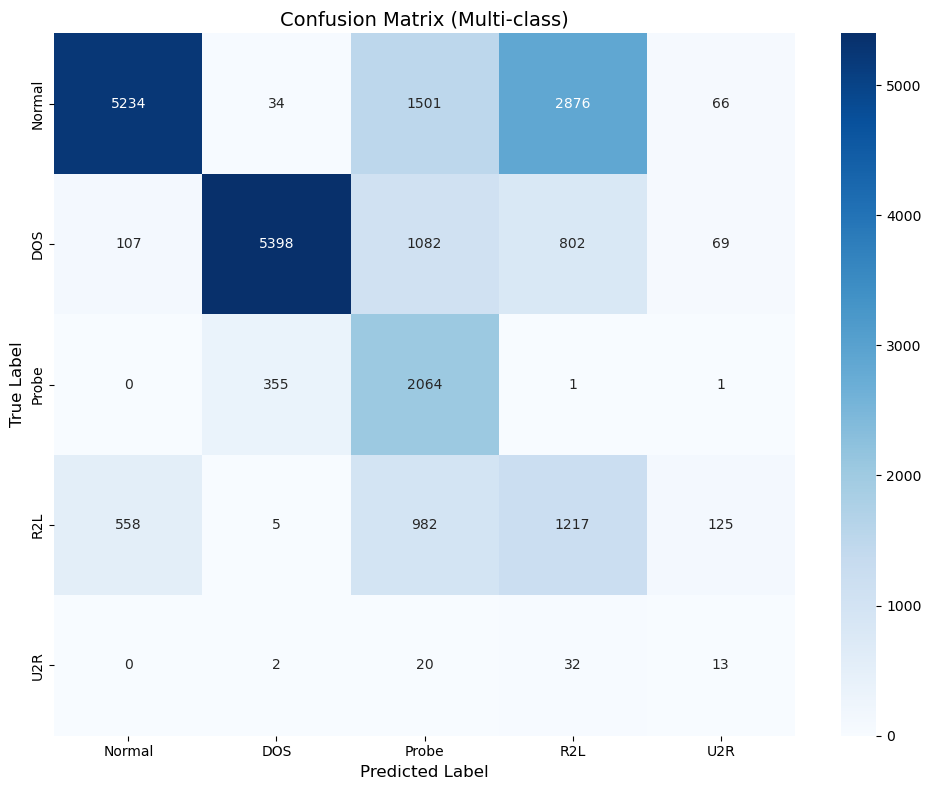

In [14]:
# Create confusion matrix
plt.figure(figsize=(10, 8))

# Use test_confusion as confusion matrix data
conf_matrix_np = test_confusion

# Create short labels
short_labels = ['Normal', 'DOS', 'Probe', 'R2L', 'U2R']

# Create heatmap
sns.heatmap(conf_matrix_np, annot=True, fmt='d', cmap='Blues',
            xticklabels=short_labels, yticklabels=short_labels)

# Add labels
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.title('Confusion Matrix (Multi-class)', fontsize=14)

# Adjust layout
plt.tight_layout()

# Save image
plt.savefig('confusion_matrix.png', dpi=300)

# Display image
plt.show()